In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import gzip
import pickle
import pdb
import gzip
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import gc
from IPython.core.debugger import set_trace

train_data = datasets.CIFAR10('/Users/Chris/Downloads',train = True, download= True, transform= transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.ToTensor(), transforms.Normalize([0],[1]),]))
test_data = datasets.CIFAR10('/Users/Chris/Downloads',train = False, download= True, transform= transforms.Compose([transforms.ToTensor()]))

criterion = nn.CrossEntropyLoss()
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        
        self.conv1 = nn.Conv2d(3, 32, 5, stride=1,padding=2)
        self.conv2 = nn.Conv2d(32, 32, 5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
        self.fc1 = nn.Linear(1024, 64)
        self.fc2 = nn.Linear(64, 10)
        self.act = nn.Softmax()
        self.relu = nn.ReLU()
        self.conv_bn1 = nn.BatchNorm2d(32)
        self.conv_bn2 = nn.BatchNorm2d(32)
        self.conv_bn3 = nn.BatchNorm2d(64)
        self.fc_bn = nn.BatchNorm1d(64)

    def forward(self, x):
        x = F.relu(self.conv_bn1(self.conv1(x)))
        x = F.avg_pool2d(x,2,stride = 2)
        x = F.relu(self.conv_bn2(self.conv2(x)))
        x = F.avg_pool2d(x,2,stride = 2)
        x = F.relu(self.conv_bn3(self.conv3(x)))
        x = F.avg_pool2d(x,2,stride = 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc_bn(self.fc1(x)))
        x = self.act(self.fc2(x))
        return x
        # Activation function, editable

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net = Net()
net = net.to(device)
optimizer = optim.SGD(net.parameters(), lr=0.2)
net.zero_grad()
trainloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=500, shuffle=True)
dataiter = iter(trainloader)
i = 0
j = 0
count = 0
test_accuracy = 0
accuracy_vector = []
test_accuracy_vector = []

for j in range(0,100):
  train_data = datasets.CIFAR10('/Users/Chris/Downloads',train = True, download= True, transform= transforms.Compose([transforms.RandomHorizontalFlip(p=0.5), transforms.RandomCrop(32, padding=4), transforms.ToTensor(), transforms.Normalize([0],[1]),]))
  trainloader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)
  dataiter = iter(trainloader)
  if  i > 10000:
    break
  for batch in dataiter:
    #print(count)
    if  i > 10000:
      break
    image = batch[0]
    #image = image*2 -1
    label = batch[1]
    # Transfer to GPU
    image, label = image.to(device), label.to(device)
    #print(net(local_batch))
    optimizer.zero_grad()
    output = net(image)
    #print(output.argmax(1))
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    i = i+1
    z = output.max(1)
    correct_guesses = z[1] == label
    correct_guesses = correct_guesses.type(torch.FloatTensor)
    accuracy = correct_guesses.mean()
    accuracy_vector.append(accuracy*100)
    count = count + 1
    if count == 500:
      print(test_accuracy)
      print(i)
      testiter = iter(testloader)
      count = 0
      for test_batch in testiter:
        test_image = test_batch[0]
        test_label = test_batch[1]
        test_image, test_label = test_image.to(device), test_label.to(device)
        outputtest = net(test_image)
        ztest = outputtest.max(1)
        test_correct_guesses = ztest[1] == test_label
        test_correct_guesses = test_correct_guesses.type(torch.FloatTensor)
        test_accuracy = test_correct_guesses.mean()
        test_accuracy_vector.append(test_accuracy*100)
        break

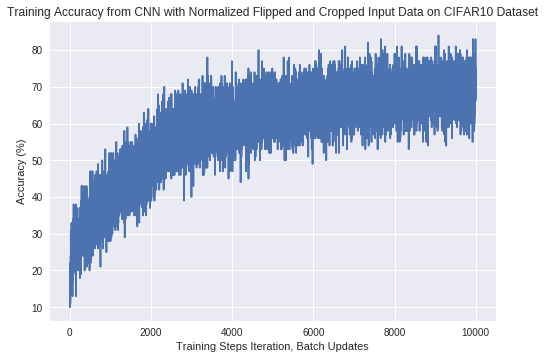

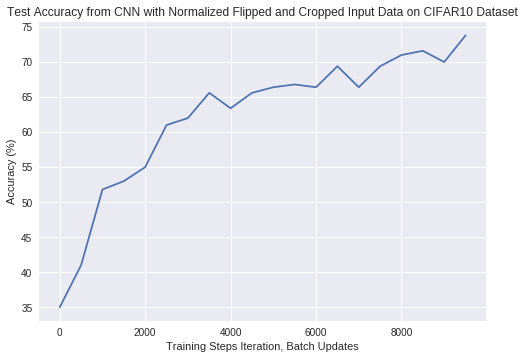

In [42]:
plt.plot(np.arange(len(accuracy_vector)),accuracy_vector)
plt.xlabel('Training Steps Iteration, Batch Updates')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy from CNN with Normalized Flipped and Cropped Input Data on CIFAR10 Dataset')
plt.show()

plt.plot(500*np.arange(len(test_accuracy_vector)),test_accuracy_vector)
plt.xlabel('Training Steps Iteration, Batch Updates')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy from CNN with Normalized Flipped and Cropped Input Data on CIFAR10 Dataset')
plt.show()